# Example 06: Gas metering station uncertainty calculations

This notebook demonstrates uncertainty calculations for a gas metering station consisting of an Ultrasonic Flowmeter (USM), a Gas Chromatograph (GC) and dual pressure and temperature measurements. 
Evaluations are done using both standard uncertainty calculations (based on sensitivity coefficients and input uncertainties), as well as the Monte Carlo Method. 

In [106]:
# Import Required Libraries
import pvtlib
from uncertaintylib import uncertainty_functions, plot_functions
import pandas as pd
import matplotlib.pyplot as plt
import os


### Read inputs from CSV file

The inputs to the uncertainty calculation is given in a csv file. 

The input contains:
- Pressure
- Temperature
- Actual volume flowrate measured by the USM
- The calibration curve for the USM
- Gas composition measured by the GC

In [107]:
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
data_path = os.path.join(notebook_dir, 'data.csv')
df = pd.read_csv(data_path)

df # Display the dataframe

,input_name,unit,mean,standard_uncertainty,standard_uncertainty_percent,distribution,min,max
0,USM_pressure_A,bara,140.00,0.150,NaN,normal,NaN,NaN
1,USM_pressure_B,bara,140.00,0.150,NaN,normal,NaN,NaN
2,USM_temperature_A,C,50.00,0.150,NaN,normal,NaN,NaN
3,USM_temperature_B,C,50.00,0.150,NaN,normal,NaN,NaN
4,USM_volflow,m3/h,14700.00,0.300,0.05,normal,NaN,NaN
5,USM_calib_volflow_01,m3/h,2332.00,NaN,0.16,normal,NaN,NaN
6,USM_calib_volflow_02,m3/h,3888.00,NaN,0.10,normal,NaN,NaN
7,USM_calib_volflow_03,m3/h,6480.00,NaN,0.09,normal,NaN,NaN
8,USM_calib_volflow_04,m3/h,10800.00,NaN,0.07,normal,NaN,NaN
9,USM_calib_volflow_05,m3/h,18000.00,NaN,0.07,normal,NaN,NaN


# Convert dataframe to dictionary
Input to uncertaintylib must be a dictionary. Convert the dataframe to a dictionary

In [108]:
df=df.set_index('input_name')

inputs = df.to_dict() # Convert dataframe to dictionary, which is the required format for uncertaintylib

### Define the function performing the gas metering station calculations

In [109]:
def calculate_gas_metering_station(inarray):
    """
    Function to calculate the gas metering station output parameters.
    Inputs is a dictionary with all input parameters.
    Outputs is a dictionary with all output parameters.
    """

    outarray = {}   # Create an empty dictionary to store output parameters. 

    # Set up AGA8 object for GERG-2008 equation. This process runs the setup for the given equation
    gerg = pvtlib.AGA8('GERG-2008')

    composition = {
        'N2' : inputs['mean']['N2'],
        'CO2' : inputs['mean']['CO2'],
        'C1' : inarray['C1'],
        'C2' : inarray['C2'],
        'C3' : inarray['C3'],
        'iC4' : inarray['iC4'],
        'nC4' : inarray['nC4'],
    }

    outarray['USM_Pressure_used'] = (inarray['USM_pressure_A']+inarray['USM_pressure_B'])/2 # Calculate average pressure
    outarray['USM_Temperature_used'] = (inarray['USM_temperature_A']+inarray['USM_temperature_B'])/2 # Calculate average temperature

    # Calculate gas properties
    gas_properties = gerg.calculate_from_PT(
        composition=composition,
        pressure=outarray['USM_Pressure_used'],
        temperature=outarray['USM_Temperature_used'],
        pressure_unit='bara',
        temperature_unit='C',
    )

    # Store results in output dictionary
    # Gas density is multiplied with an uncertainty factor to account for uncertainty in the GERG-2008 equation of state. The value of the factor is 1, but the uncertainty is +/- 0.1 % (k=2)
    outarray['Gas_Density'] = gas_properties['rho']*inarray['GERG_uncertainty_factor']  # Gas density in kg/m3
    outarray['Gas_Compressibility'] = gas_properties['z']  # Gas compressibility factor
    outarray['Gas_Molar_Mass'] = gas_properties['mm']  # Gas molar mass in kg/kmol

    # Get calibration curves from inarray
    USM_calib_volflow = [
        inarray['USM_calib_volflow_01'],
        inarray['USM_calib_volflow_02'],
        inarray['USM_calib_volflow_03'],
        inarray['USM_calib_volflow_04'],
        inarray['USM_calib_volflow_05'],
        inarray['USM_calib_volflow_06'],
    ]

    USM_calib_error = [
        inarray['USM_calib_error_01'],
        inarray['USM_calib_error_02'],
        inarray['USM_calib_error_03'],
        inarray['USM_calib_error_04'],
        inarray['USM_calib_error_05'],
        inarray['USM_calib_error_06'],
    ]

    # Retrieve the calibration error for the measured volume flow, using linear interpolation
    outarray['USM_calib_error_used'] = pvtlib.utilities.linear_interpolation(
        x=inarray['USM_volflow'],
        x_values=USM_calib_volflow,
        y_values=USM_calib_error
    )

    # Calculate volume flowrate corrected for calibration error
    outarray['USM_volflow_corrected'] = inarray['USM_volflow']/((outarray['USM_calib_error_used']/100)+1)  # Corrected volume flow in m3/h

    # Calculate mass flowrate
    outarray['USM_massflow'] = outarray['USM_volflow_corrected'] * outarray['Gas_Density'] # Mass flow in kg/h

    # Calculate gas properties at standard conditions (288.15 K (15.00 °C) and 101.325 kPa according to ISO 13443)
    gas_properties_std = gerg.calculate_from_PT(
        composition=composition,
        pressure=101.325,
        temperature=288.15,
        pressure_unit='kPa',
        temperature_unit='K',
    )

    # Calculate volume flowrate at standard conditions
    outarray['USM_volflow_std'] = outarray['USM_massflow'] / gas_properties_std['rho']  # Standard volume flow in Sm3/h

    return outarray

### Calculate uncertainty using sensitivity coefficients and input uncertainties
Uncertainty is calculated using the function "calculate_uncertainty", which returns a dictionary with the following results.
- value: The actual output values returned from the function (based on the 'mean' input values)
- variance: The varians for each input parameter for each output parameter.
- contribution: The percentage contribution of each input variable to the uncertainty in each output variable.
- u: Combined Standard Uncertainty (u) for each output parameter.
- U: Expanded Uncertainty (95% confidence level)(U,k=2) for each output parameter.
- U_perc: Relative Expanded Uncertainty (95% confidence level)(U, k=2) for each output parameter, in %.


In [110]:
uncertainty_results = uncertainty_functions.calculate_uncertainty(
    indata=inputs,
    function=calculate_gas_metering_station
)

### Print gas properties including uncertainties

In [111]:

# Print uncertainty in mass density, molar mass and compressibility factor
print('--- Gas Properties Uncertainty Results ---')
print(f'Gas Density: {uncertainty_results["value"]["Gas_Density"]:.2f} kg/m3 ± {uncertainty_results["U_perc"]["Gas_Density"]:.2f} % (k=2)')
print(f'Gas Molar Mass: {uncertainty_results["value"]["Gas_Molar_Mass"]:.2f} kg/kmol ± {uncertainty_results["U_perc"]["Gas_Molar_Mass"]:.2f} % (k=2)')
print(f'Gas Compressibility: {uncertainty_results["value"]["Gas_Compressibility"]:.2f} ± {uncertainty_results["U_perc"]["Gas_Compressibility"]:.2f} % (k=2)')

--- Gas Properties Uncertainty Results ---
Gas Density: 113.10 kg/m3 ± 0.48 % (k=2)
Gas Molar Mass: 18.13 kg/kmol ± 0.27 % (k=2)
Gas Compressibility: 0.84 ± 0.16 % (k=2)


### Print flowrates including uncertainties

In [112]:
print('\n--- Flowrate Uncertainty Results ---')
print(f"Volume Flowrate (corrected for calibration error): {uncertainty_results['value']['USM_volflow_corrected']:,.1f} m3/h ± {uncertainty_results['U_perc']['USM_volflow_corrected']:,.2f} % (k=2)")
print(f"Volume Flowrate (standard conditions): {uncertainty_results['value']['USM_volflow_std']:,.1f} Sm3/h ± {uncertainty_results['U_perc']['USM_volflow_std']:,.2f} % (k=2)")
print(f"Mass Flowrate: {uncertainty_results['value']['USM_massflow']:,.1f} kg/h ± {uncertainty_results['U_perc']['USM_massflow']:,.2f} % (k=2)")


--- Flowrate Uncertainty Results ---
Volume Flowrate (corrected for calibration error): 14,693.0 m3/h ± 0.16 % (k=2)
Volume Flowrate (standard conditions): 2,162,392.8 Sm3/h ± 0.31 % (k=2)
Mass Flowrate: 1,661,711.4 kg/h ± 0.50 % (k=2)


### Plot contributions to uncertainty in Standard Volumetric Flowrate

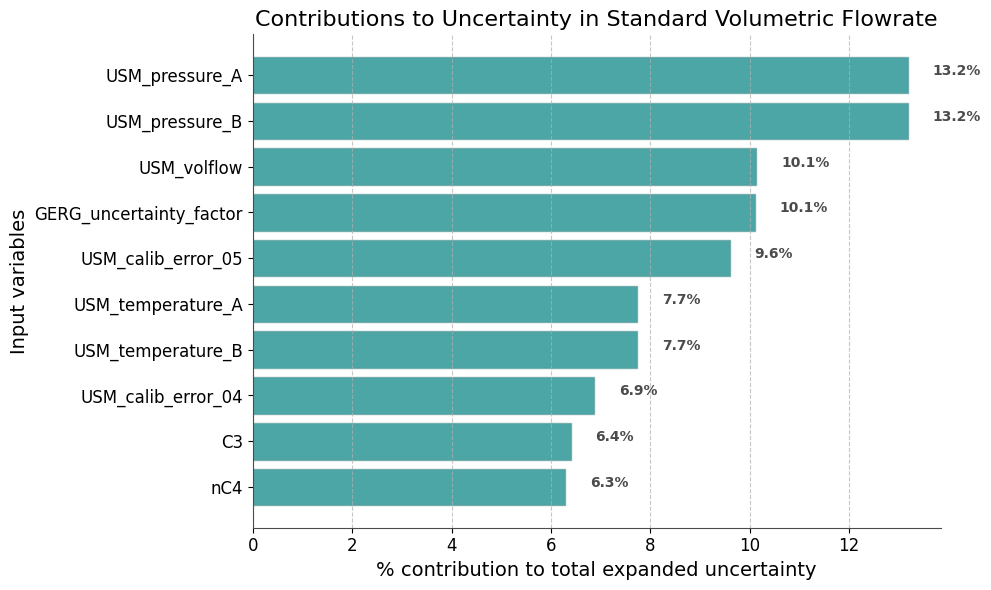

In [113]:
fig1=plot_functions.plot_uncertainty_contribution(
    res=uncertainty_results,
    property_id='USM_volflow_std',
    plot_title='Contributions to Uncertainty in Standard Volumetric Flowrate',
    filter_top_x=10
)

## Plot calibration curve and the operating point

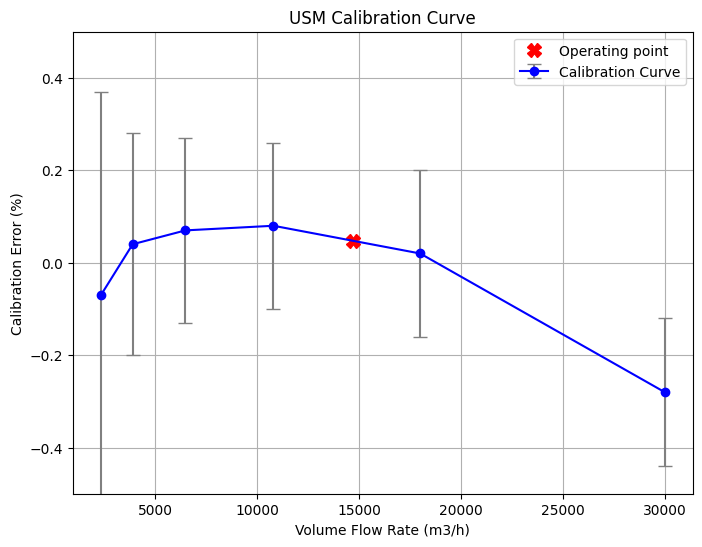

In [ ]:
# Get the calibration data from inputs
USM_calib_volflow = [
    inputs['mean']['USM_calib_volflow_01'],
    inputs['mean']['USM_calib_volflow_02'],
    inputs['mean']['USM_calib_volflow_03'],
    inputs['mean']['USM_calib_volflow_04'],
    inputs['mean']['USM_calib_volflow_05'],
    inputs['mean']['USM_calib_volflow_06'],
]

USM_calib_error = [
    inputs['mean']['USM_calib_error_01'],
    inputs['mean']['USM_calib_error_02'],
    inputs['mean']['USM_calib_error_03'],
    inputs['mean']['USM_calib_error_04'],
    inputs['mean']['USM_calib_error_05'],
    inputs['mean']['USM_calib_error_06'],
]

# Get uncertainties in the calibration error points (k=2)
USM_calib_error_uncertainty = [
    2 * inputs['standard_uncertainty']['USM_calib_error_01'],
    2 * inputs['standard_uncertainty']['USM_calib_error_02'],
    2 * inputs['standard_uncertainty']['USM_calib_error_03'],
    2 * inputs['standard_uncertainty']['USM_calib_error_04'],
    2 * inputs['standard_uncertainty']['USM_calib_error_05'],
    2 * inputs['standard_uncertainty']['USM_calib_error_06'],
]

# Plot the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    USM_calib_volflow,
    USM_calib_error,
    yerr=USM_calib_error_uncertainty,
    fmt='o-',
    color='b',
    ecolor='gray',
    capsize=5,
    label='Calibration Curve'
)
plt.plot(
    inputs['mean']['USM_volflow'],
    uncertainty_results['value']['USM_calib_error_used'],
    marker='X',
    color='r',
    markersize=10,
    linestyle='None',
    label='Operating point'
)
plt.xlabel('Volume Flow Rate (m3/h)')
plt.ylabel('Calibration Error (%)')
plt.title('USM Calibration Curve')
plt.ylim([-1.0, 1.0])
plt.legend()
plt.grid()
plt.show()


## Run Monte Carlo simulation
Uncertainties can also be determined by using the Monte Carlo method. 
In this method, uncertainty distributions for each input variable is generated randomly, and then the outputs are calculated from the input distributions. The standard deviation of the resulting output distribution will reflect the uncertainty of that given output parameter.



In [115]:
monte_carlo_results = uncertainty_functions.monte_carlo_simulation(
    mc_input=inputs,
    function=calculate_gas_metering_station,
    n=10000
)

# The monte_carlo_results is a dataframe with the results of the Monte Carlo simulation
# The 'calculate_monte_carlo_statistics' is used to calculate the mean, standard deviations and relative standard deviations of the results
monte_carlo_statistics = uncertainty_functions.calculate_monte_carlo_statistics(monte_carlo_results)

# Display the Monte Carlo statistics
monte_carlo_statistics

,mean,std_dev,std_dev_percent,std_dev_k2,std_dev_percent_k2
USM_Pressure_used,1.400004e+02,0.106286,0.075918,0.212572,0.151837
USM_Temperature_used,4.999923e+01,0.106189,0.212381,0.212377,0.424761
Gas_Density,1.130943e+02,0.269114,0.237955,0.538228,0.475911
Gas_Compressibility,8.350750e-01,0.000664,0.079462,0.001327,0.158923
Gas_Molar_Mass,1.812478e+01,0.024908,0.137424,0.049816,0.274849
USM_calib_error_used,4.744785e-02,0.063949,134.776406,0.127897,269.552813
USM_volflow_corrected,1.469310e+04,11.882549,0.080872,23.765097,0.161743
USM_massflow,1.661706e+06,4171.069054,0.251011,8342.138107,0.502023
USM_volflow_std,2.162413e+06,3362.286269,0.155488,6724.572537,0.310975


### Print the flowrate uncertainty results from the Monte Carlo simulation

In [116]:
print('\n--- Flowrate Uncertainty Results ---')
print(f"Volume Flowrate (corrected for calibration error): {monte_carlo_statistics.loc['USM_volflow_corrected', 'mean']:,.1f} m3/h ± {monte_carlo_statistics.loc['USM_volflow_corrected', 'std_dev_percent_k2']:,.2f} % (k=2)")
print(f"Volume Flowrate (standard conditions): {monte_carlo_statistics.loc['USM_volflow_std', 'mean']:,.1f} Sm3/h ± {monte_carlo_statistics.loc['USM_volflow_std', 'std_dev_percent_k2']:,.2f} % (k=2)")
print(f"Mass Flowrate: {monte_carlo_statistics.loc['USM_massflow', 'mean']:,.1f} kg/h ± {monte_carlo_statistics.loc['USM_massflow', 'std_dev_percent_k2']:,.2f} % (k=2)")


--- Flowrate Uncertainty Results ---
Volume Flowrate (corrected for calibration error): 14,693.1 m3/h ± 0.16 % (k=2)
Volume Flowrate (standard conditions): 2,162,413.2 Sm3/h ± 0.31 % (k=2)
Mass Flowrate: 1,661,706.0 kg/h ± 0.50 % (k=2)


### Plot the distribution for the Standard Volumetric Flowrate

c:\Appl\GitHub\uncertaintylib\.venv\Lib\site-packages\uncertaintylib\plot_functions.py:127: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


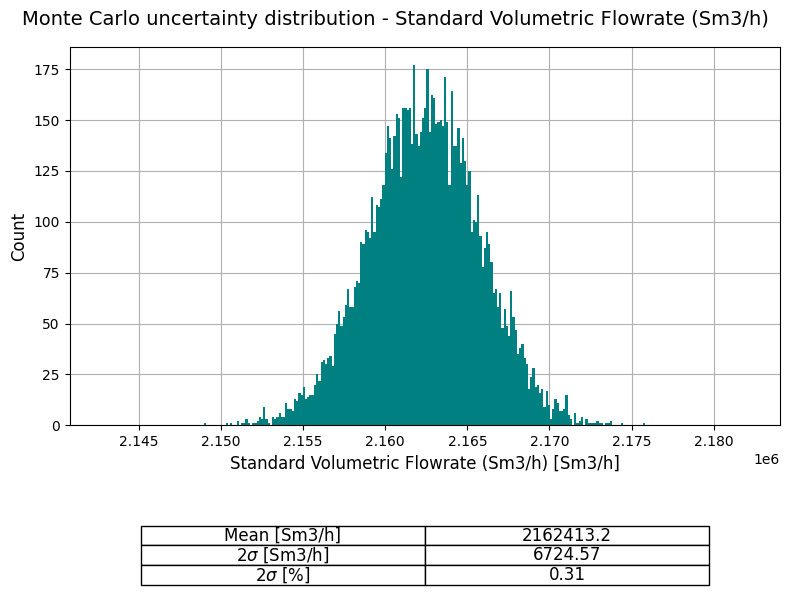

In [117]:
fig2 = plot_functions.montecarlo_property_plot_and_table(
    data=monte_carlo_results,
    property_id='USM_volflow_std',
    xlim=[-1,1],
    property_name='Standard Volumetric Flowrate (Sm3/h)',
    property_unit='Sm3/h',
    round_props={'mean': 1, 'std': 2, 'stdperc': 2}
)